In [1]:
import sys, os, time
import torch
sys.path.append("../src/")
from run_pdebench_finetuning import get_args, get_model, build_pdebench_dataset
from engine_for_pdebench_finetuning import get_targets, unnorm_batch
import utils
from einops import rearrange
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate

In [2]:
model_dir = 'pdebench_finetuning/ssv2_b/final_runs/ssv2_b_turb_512_0.8'
out_filename = 'ssv2_b_turb_512_0.8_v4.mp4'

args_json = os.path.join(utils.get_ceph_dir(), model_dir, "args.json")
args = utils.load_args(args_json)

args.num_workers = 1
args.device = 'cuda:0'
args.checkpoint = os.path.join(model_dir, 'checkpoint-499')

In [3]:
n_pred_frames = 20

In [4]:
print("Dataset:\t\t", args.data_set)
print("Fields:\t\t\t", args.fields)
print("Model:\t\t\t", args.model)
print("Checkpoint:\t\t", args.checkpoint)
print("Batch size:\t\t", args.batch_size)
print("Number of workers:\t", args.num_workers)
print("Mask type:\t\t", args.mask_type)
print("Mask ratio:\t\t", args.mask_ratio)
print("Norm target mode:\t", args.norm_target_mode)
print("Num frames:\t\t", args.num_frames)
print("Device:\t\t\t", args.device)

Dataset:		 compNS_turb
Fields:			 ['Vx', 'Vy', 'density', 'pressure']
Model:			 pretrain_videomae_base_patch16_512_4chan_18f
Checkpoint:		 pdebench_finetuning/ssv2_b/final_runs/ssv2_b_turb_512_0.8/checkpoint-499
Batch size:		 1
Number of workers:	 1
Mask type:		 last_frame
Mask ratio:		 0.9
Norm target mode:	 last_frame
Num frames:		 18
Device:			 cuda:0


In [5]:
device = torch.device(args.device)

# Load model
model = get_model(args)
model.to(device)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model loaded")
print('number of params: {} M'.format(n_parameters / 1e6))

# Load dataset
dataset = build_pdebench_dataset(args, set_type='test')
data_norm_tf = dataset.transform.transform.transforms[1] # CustomNormalize object to unnormalize data
dataset.timesteps = 21
dataset.random_start = False

# Data loader
# sampler = torch.utils.data.RandomSampler(dataset)
sampler = torch.utils.data.SequentialSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, sampler=sampler,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
        worker_init_fn=utils.seed_worker)

Creating model: pretrain_videomae_base_patch16_512_4chan_18f
Position interpolate from 8x14x14 to 9x32x32
Position interpolate from 8x14x14 to 9x32x32
Adapting checkpoint for PDEBench
Model loaded
number of params: 94.80128 M
Loading dataset file /mnt/home/gkrawezik/ceph/AI_DATASETS/PDEBench/2D/CFD/2D_Train_Turb/2D_CFD_Turb_M1.0_Eta1e-08_Zeta1e-08_periodic_512_Train.hdf5
Raw dataset compNS_turb has 1000 samples of shape (512, 512) and 21 timesteps.


In [6]:
def loss_func_nrmse(input, target, mean_dim=None):
    x = torch.sqrt(torch.mean(torch.square(input - target), dim=(-1, -2)) / torch.mean(torch.square(target) + 1e-7, dim=(-1, -2)))
    return x.mean(dim=mean_dim)

In [7]:
loss_func = nn.MSELoss()

max_examples = 1

model.eval()
for samples_base, masks in data_loader:
    samples_base = samples_base.to(device, non_blocking=True)
    samples_truth = samples_base.clone()

    bool_masked_pos = masks.to(device, non_blocking=True).flatten(1).to(torch.bool)

    p0, p1, p2 = 2, args.patch_size[0], args.patch_size[1]
    h, w = args.input_size // p1, args.input_size // p2
    nchan = samples_base.shape[1]
    
    # Extend samples_base
    samples_base = torch.cat([samples_base,
                              samples_base[:, :, -1:].repeat(1, 1, n_pred_frames-2, 1, 1)], dim=2)

    for i in range(args.num_frames, args.num_frames + n_pred_frames + 2):
        samples = samples_base[:, :, i-args.num_frames:i]

        with torch.no_grad():
            outputs = model(samples, bool_masked_pos)
            outputs_unnorm = unnorm_batch(outputs,
                                        norm_mode=args.norm_target_mode,
                                        patch_size=(p0, p1, p2),
                                        context=samples,
                                        bool_masked_pos=bool_masked_pos)
            
            recon_full = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
            recon_full[bool_masked_pos] = outputs_unnorm.flatten(start_dim=0, end_dim=1)
            recon_full = rearrange(recon_full, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=p0, p1=p1, p2=p2, h=h, w=w)
            samples_base[:, :, i-2] = recon_full[:, :, -2]

            # We only compute the loss on the first predicted frame
            outputs = outputs.reshape(outputs.shape[0], outputs.shape[1], p0, p1, p2, nchan)[:, 0, :, :, :]
            outputs = outputs.reshape(outputs.shape[0], outputs.shape[1], -1)
            
    samples_base = samples_base[:, :, :-1]
    max_examples -= 1
    if max_examples == 0:
        break

# Unnormalize data
samples_base_unnorm = data_norm_tf.unnormalize(samples_base.cpu())
samples_truth_unnorm = data_norm_tf.unnormalize(samples_truth.cpu())

In [8]:
def make_video_v1(recon, out_filename):
    recon = recon[0].cpu().numpy()

    nframes = recon.shape[-3]

    fps = 1
    nSeconds = nframes

    vmin = np.min(recon, axis=(-1, -2, -3))
    vmax = np.max(recon, axis=(-1, -2, -3))

    ims = [None,] * len(args.fields)

    i = 0
    fig, axs = plt.subplots(1, len(args.fields), figsize=(3*len(args.fields), 3), sharex=True, sharey=True)
    for j in range(len(args.fields)):
        ims[j] = axs[j].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
    for j in range(len(args.fields)):
        axs[j].set_title(args.fields[j] + ' - Frame {}'.format(i))
    fig.tight_layout()

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        for j in range(len(args.fields)):
            ims[j].set_array(recon[j, i, :, :])
            suffix = '(Context)' if i < args.num_frames - 2 else '(Prediction)'
            axs[j].set_title(args.fields[j] + ' - Frame {} '.format(i) + suffix)
        return ims

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = nSeconds * fps,
                                interval = 1000 / fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, bitrate=1800)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

In [9]:
def make_video_v2(recon, out_filename):
    recon = recon[0].cpu().numpy()

    nframes = recon.shape[-3]

    fps = 2
    total_fps = 30
    nSeconds = nframes // fps

    vmin = np.min(recon, axis=(-1, -2, -3))
    vmax = np.max(recon, axis=(-1, -2, -3))

    ims = [None,] * len(args.fields)

    i = 0
    fig, axs = plt.subplots(1, len(args.fields), figsize=(3*len(args.fields), 3), sharex=True, sharey=True)
    for j in range(len(args.fields)):
        ims[j] = axs[j].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
    for j in range(len(args.fields)):
        axs[j].set_title(args.fields[j] + ' - Frame {}'.format(i))
    fig.tight_layout()

    def animate_func(i):
        if i % total_fps == 0:
            print( '.', end ='' )
        i_eff = i // (total_fps // fps)
        i_eff_mod = i % (total_fps // fps)
        if i_eff != nframes - 1:
            f_interp = interpolate.interp1d([0, total_fps // fps], [recon[:, i_eff, :, :], recon[:, i_eff+1, :, :]], axis=0)
            recon_interp = f_interp(i_eff_mod)
        else:
            recon_interp = recon[:, i_eff, :, :]
        for j in range(len(args.fields)):
            ims[j].set_array(recon_interp[j, :, :])
            suffix = '(Context)' if i_eff < args.num_frames - 2 else '(Prediction)'
            axs[j].set_title(args.fields[j] + ' - Frame {} '.format(i_eff) + suffix)
        return ims

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = nSeconds * total_fps,
                                interval = 1000 / total_fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=total_fps, bitrate=5000)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

In [10]:
def make_video_v3(recon, truth, out_filename, fields_labels=None):
    if fields_labels is None:
        fields_labels = args.fields

    recon = recon[0].cpu().numpy()
    truth = truth[0].cpu().numpy()

    nframes = recon.shape[-3]
    nframes_truth = truth.shape[-3]

    fps = 2
    total_fps = 2
    nSeconds = nframes // fps

    vmin = np.min(recon, axis=(-1, -2, -3))
    vmax = np.max(recon, axis=(-1, -2, -3))

    ims = []
    for i in range(3):
        ims.append([None,] * len(args.fields))

    i = 0
    fig, axs = plt.subplots(3, len(args.fields), figsize=(3*len(args.fields), 9), sharex=True, sharey=True)
    for j in range(len(args.fields)):
        ims[0][j] = axs[0, j].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        ims[1][j] = axs[1, j].imshow(truth[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        ims[2][j] = axs[2, j].imshow(recon[j, i, :, :] - truth[j, i, :, :], vmin=-vmax[j], vmax=vmax[j])
    for j in range(len(args.fields)):
        axs[0, j].set_title(fields_labels[j])
    axs[0, 0].set_ylabel('Reconstruction')
    axs[1, 0].set_ylabel('Ground truth')
    axs[2, 0].set_ylabel('Difference')
    fig.suptitle('Frame 0 - (Context)')
    fig.tight_layout()

    def animate_func(i):
        if i % total_fps == 0:
            print( '.', end ='' )
        i_eff = i // (total_fps // fps)
        i_eff_mod = i % (total_fps // fps)
        if i_eff != nframes - 1:
            f_rec_interp = interpolate.interp1d([0, total_fps // fps], [recon[:, i_eff, :, :], recon[:, i_eff+1, :, :]], axis=0)
            recon_interp = f_rec_interp(i_eff_mod)
        else:
            recon_interp = recon[:, i_eff, :, :]
        if i_eff < nframes_truth - 1:
            f_tru_interp = interpolate.interp1d([0, total_fps // fps], [truth[:, i_eff, :, :], truth[:, i_eff+1, :, :]], axis=0)
            truth_interp = f_tru_interp(i_eff_mod)
            f_diff_interp = interpolate.interp1d([0, total_fps // fps], [recon[:, i_eff, :, :] - truth[:, i_eff, :, :], recon[:, i_eff+1, :, :] - truth[:, i_eff+1, :, :]], axis=0)
            diff_interp = f_diff_interp(i_eff_mod)
        elif i_eff == nframes_truth - 1:
            truth_interp = truth[:, -1, :, :]
            diff_interp = recon[:, i_eff, :, :] - truth[:, -1, :, :]
        else:
            truth_interp = np.empty_like(truth[:, -1, :, :])
            truth_interp[:] = np.nan
            diff_interp = np.empty_like(truth[:, -1, :, :])
            diff_interp[:] = np.nan
        if i_eff >= args.num_frames - 2 and i_eff < nframes_truth:
            nrmse = loss_func_nrmse(torch.from_numpy(recon[:, i_eff, :, :]), torch.from_numpy(truth[:, i_eff, :, :])).item()
            suffix = f'(Prediction - NRMSE = {nrmse:.3f})'
        elif i_eff >= nframes_truth:
            suffix = '(Prediction - NRMSE = N/A)'
        else:
            suffix = '(Context)'
        for j in range(len(args.fields)):
            ims[0][j].set_array(recon_interp[j, :, :])
            ims[1][j].set_array(truth_interp[j, :, :])
            ims[2][j].set_array(diff_interp[j, :, :])

        fig.suptitle(f'Frame {i_eff} - ' + suffix)

        return ims

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = nSeconds * total_fps,
                                interval = 1000 / total_fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=total_fps, bitrate=5000)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

In [38]:
def compute_power_spectrum(recon, truth):
    bins = torch.linspace(0, np.pi, 100)
    bins, ps_recon, _ = utils.power_spectrum_iso2d(torch.from_numpy(recon).unsqueeze(0), bins=bins)
    if truth is not None:
        bins, ps_truth, _ = utils.power_spectrum_iso2d(torch.from_numpy(truth).unsqueeze(0), bins=bins)
        bins, ps_diff, _ = utils.power_spectrum_iso2d(torch.from_numpy(recon - truth).unsqueeze(0), bins=bins)

    bins = bins.cpu().numpy()
    ps_recon = ps_recon.cpu().numpy()[0]
    if truth is not None:
        ps_truth = ps_truth.cpu().numpy()[0]
        ps_diff = ps_diff.cpu().numpy()[0]
    else:
        ps_truth = np.empty_like(ps_recon)
        ps_truth[:] = np.nan
        ps_diff = np.empty_like(ps_recon)
        ps_diff[:] = np.nan

    bins_centers = 0.5 * (bins[1:] + bins[:-1])
        
    return bins_centers, ps_truth[:, :, :-1], ps_recon[:, :, :-1], ps_diff[:, :, :-1]


def make_video_v4(recon, truth, out_filename, recon_unnorm=None, truth_unnorm=None, fields_labels=None):
    if fields_labels is None:
        fields_labels = args.fields
    
    if recon_unnorm is None:
        recon_unnorm = recon.clone()
    if truth_unnorm is None:
        truth_unnorm = truth.clone()

    recon = recon[0].cpu().numpy()
    truth = truth[0].cpu().numpy()
    recon_unnorm = recon_unnorm[0].cpu().numpy()
    truth_unnorm = truth_unnorm[0].cpu().numpy()

    nframes = recon.shape[-3]
    nframes_truth = truth.shape[-3]

    fps = 2
    total_fps = 2
    nSeconds = nframes // fps

    vmin = np.min(recon, axis=(-1, -2, -3))
    vmax = np.max(recon, axis=(-1, -2, -3))

    ims = []
    for i in range(2):
        ims.append([None,] * len(args.fields))
    lines = [None, None, None] * len(args.fields)

    i = 0
    
    bins, ps_truth, ps_recon, ps_diff = compute_power_spectrum(recon[:, i], truth[:, i])

    fig, axs = plt.subplots(3, len(args.fields), figsize=(3*len(args.fields), 9))
    for j in range(len(args.fields)):
        ims[0][j] = axs[0, j].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        ims[1][j] = axs[1, j].imshow(truth[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        lines[3*j] = axs[2, j].plot(bins, ps_truth[j, j], label='Ground truth')[0]
        lines[3*j+1] = axs[2, j].plot(bins, ps_recon[j, j], label='Reconstruction')[0]
        lines[3*j+2] = axs[2, j].plot(bins, ps_diff[j, j], label='Difference')[0]
    for j in range(len(args.fields)):
        axs[0, j].set_title(fields_labels[j])
    axs[0, 0].set_ylabel('Reconstruction')
    axs[1, 0].set_ylabel('Ground truth')
    axs[2, 0].set_ylabel('Power spectrum')
    for j in range(len(args.fields)):
        axs[2, j].set_yscale('log')
        axs[2, j].set_xscale('log')
        axs[2, j].set_xlabel('$k$')
        axs[2, j].set_ylim([1e-3, 1e8])
    axs[2, 0].legend()
    fig.suptitle('Frame 0 - (Context)')
    # Remote tick labels
    for i in range(3):
        for j in range(len(args.fields)):
            if j != 0:
                # Remove y tick labels
                axs[i, j].set_yticklabels([])
            if i == 0:
                # Remove x tick labels
                axs[i, j].set_xticklabels([])
    fig.subplots_adjust(wspace=0.15, hspace=0.15)

    def animate_func(i):
        if i % total_fps == 0:
            print( '.', end ='' )
        i_eff = i // (total_fps // fps)
        i_eff_mod = i % (total_fps // fps)
        if i_eff != nframes - 1:
            f_rec_interp = interpolate.interp1d([0, total_fps // fps], [recon[:, i_eff, :, :], recon[:, i_eff+1, :, :]], axis=0)
            recon_interp = f_rec_interp(i_eff_mod)
        else:
            recon_interp = recon[:, i_eff, :, :]
        if i_eff < nframes_truth - 1:
            f_tru_interp = interpolate.interp1d([0, total_fps // fps], [truth[:, i_eff, :, :], truth[:, i_eff+1, :, :]], axis=0)
            truth_interp = f_tru_interp(i_eff_mod)
        elif i_eff == nframes_truth - 1:
            truth_interp = truth[:, -1, :, :]
        else:
            truth_interp = np.empty_like(truth[:, -1, :, :])
            truth_interp[:] = np.nan
        if i_eff_mod == 0:
            bins, ps_truth, ps_recon, ps_diff = compute_power_spectrum(recon[:, i_eff], truth[:, i_eff] if i_eff < nframes_truth else None)
            for j in range(len(args.fields)):
                lines[3*j].set_ydata(ps_truth[j, j])
                lines[3*j+1].set_ydata(ps_recon[j, j])
                lines[3*j+2].set_ydata(ps_diff[j, j])
        if i_eff >= args.num_frames - 2 and i_eff < nframes_truth:
            nrmse = loss_func_nrmse(torch.from_numpy(recon_unnorm[:, i_eff, :, :]), torch.from_numpy(truth_unnorm[:, i_eff, :, :])).item()
            suffix = f'(Prediction - NRMSE = {nrmse:.3f})'
        elif i_eff >= nframes_truth:
            suffix = '(Prediction - NRMSE = N/A)'
        else:
            suffix = '(Context)'
        for j in range(len(args.fields)):
            ims[0][j].set_array(recon_interp[j, :, :])
            ims[1][j].set_array(truth_interp[j, :, :])

        fig.suptitle(f'Frame {i_eff} - ' + suffix)

        return ims, lines

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = nSeconds * total_fps,
                                interval = 1000 / total_fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=total_fps, bitrate=5000)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

/tmp/ipykernel_3850712/2925770455.py:70: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[2, j].set_yscale('log')


.....................

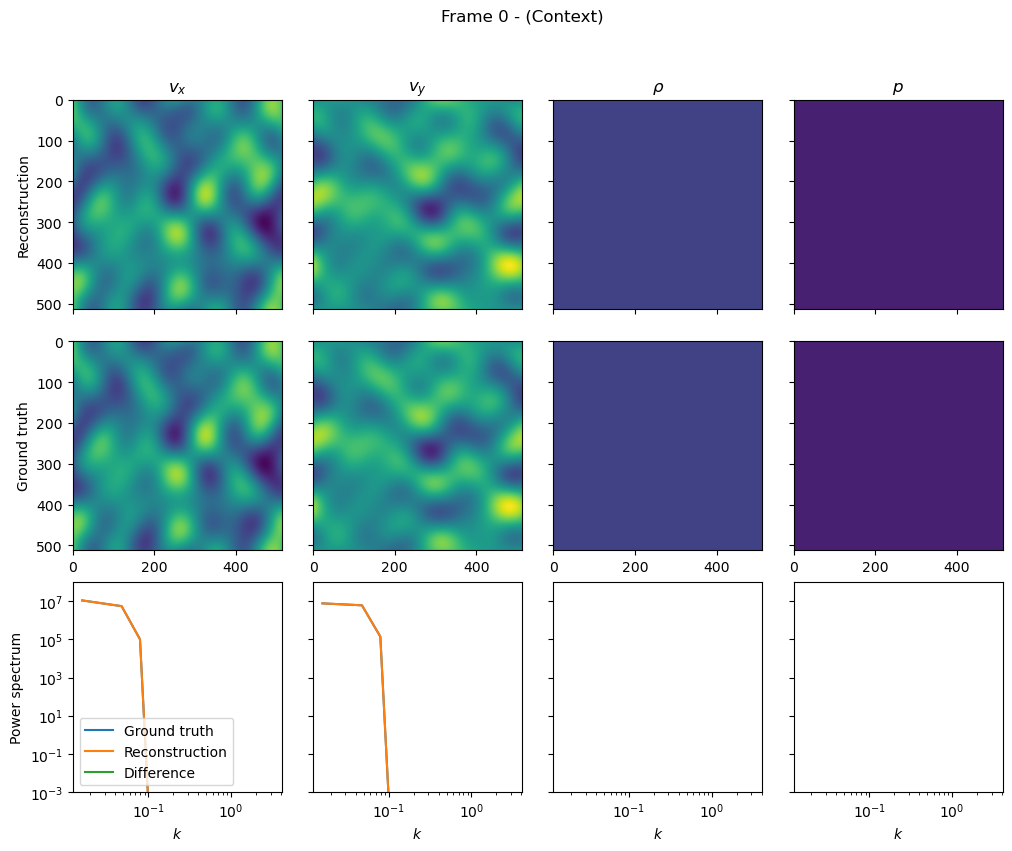

In [39]:
make_video_v4(samples_base,
              samples_truth,
              out_filename,
              fields_labels=['$v_x$', '$v_y$', '$\\rho$', '$p$'],
              recon_unnorm=samples_base_unnorm,
              truth_unnorm=samples_truth_unnorm)